In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchmetrics import Accuracy
from torchtext.vocab import GloVe

### Read data and preprocessing

In [131]:
data = pd.read_csv("/kaggle/input/imdb-dataset/IMDB_Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [133]:
data = data.dropna()

In [134]:
# trin test split
X = data["review"]
y = data["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000,), (10000,), (40000,), (10000,))

### Define tokenizer, use Glove for embedding

In [136]:
# tokenize
tokenizer = get_tokenizer("basic_english")
text = "My name is Amirali, what about you?"
tokens = tokenizer(text)
tokens

['my', 'name', 'is', 'amirali', ',', 'what', 'about', 'you', '?']

In [137]:
# use Golve as vocabulary
glove = GloVe(name="6B", dim=100)

In [138]:
def new_embedding(tokens, max_length=200, embedding_dim=100):
    tokens_array = tokenizer(tokens)
    word_embedding = map(lambda x: glove[x], tokens_array[0:max_length])
    word_embedding = np.array(list(word_embedding))
    difference = max_length - len(tokens_array)
    difference = 0 if difference < 0 else difference
    result = np.concatenate((word_embedding, np.zeros((difference,embedding_dim))))
    result = torch.from_numpy(result)
    return result

### Customise Dataset to prepare data in suitable format

In [139]:
"""
inherit from Dataset to make sure it is
compatible with Pytorch training process
"""
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X) # Return total number of samples

    def __getitem__(self, idx):

        X_sample = self.X.iloc[idx]
        y_sample = self.y.iloc[idx]
        embedded_tensor = new_embedding(X_sample)

        all_categories = ["negative", "positive"]
        label_tensor = torch.tensor(
            [all_categories.index(y_sample)], dtype=torch.float
        )
        return embedded_tensor, label_tensor

In [140]:
train_data = CustomDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)

val_data = CustomDataset(X_test, y_test)
val_loader = DataLoader(dataset=val_data, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)

### Build the model

In [141]:
input_size = 100
sequence_length = 200
hidden_size = 256
num_layers = 1
num_epochs = 7
batch_size = 128
learning_rate = 0.01
num_classes = 1

In [142]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [143]:
class ClassicSentiment(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_classes, num_layers, sequence_length
    ):
        super(ClassicSentiment, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.accuracy = Accuracy(task="binary", num_classes=2)

        self.rnn = nn.RNN(self.input_size, self.hidden_size, num_layers=self.num_layers)
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)
        x = x.float()
        output,_ = self.lstm(x, (h0.detach(), c0.detach()))
        output = self.dropout(output[:,-1,:])
        output = self.fc(output)
        output = self.sigmoid(output)
        return output


model = ClassicSentiment(
    input_size, hidden_size, num_classes, num_layers, sequence_length
)
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train, Evaluaion 

In [144]:
# train
model.to(device)
train_loss = []
train_acc = []
val_loss = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    batch_train_loss = []
    batch_train_acc = []
    for i, (embedded_tensor, label_tensor) in enumerate(train_loader):
        embedded_tensor = embedded_tensor.to(device)
        label_tensor = label_tensor.to(device)
        
        output = model(embedded_tensor)
        l = loss(output, label_tensor)
        batch_train_loss.append(l.item())
        
        predicted = torch.round(output)
        acc = torch.eq(predicted, label_tensor).sum() / batch_size
        batch_train_acc.append(acc.item())
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    epoch_loss = sum(batch_train_loss)/len(train_loader)
    epoch_acc = sum(batch_train_acc)/len(train_loader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    with torch.no_grad():
        batch_val_loss = []
        batch_val_acc = []
        for i, (embedded_tensor, label_tensor) in enumerate(val_loader):
            embedded_tensor = embedded_tensor.to(device)
            label_tensor = label_tensor.to(device)
            model.eval()
            output = model(embedded_tensor)
            l = loss(output, label_tensor)
            batch_val_loss.append(l.item())
            
            predicted = torch.round(output)
            acc = torch.eq(predicted, label_tensor).sum() / batch_size
            batch_val_acc.append(acc.item())
        epoch_loss = sum(batch_val_loss)/len(val_loader)
        epoch_acc = sum(batch_val_acc)/len(val_loader)
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)
        

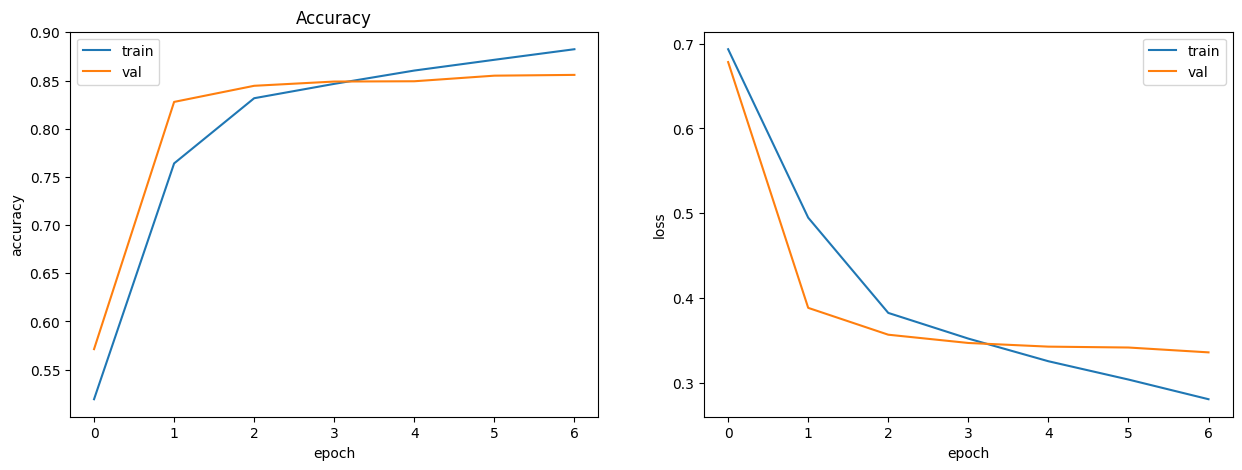

In [145]:
plt.figure(figsize=(15,5))
x_axis = [i for i in range(0,7)]
plt.subplot(1,2,1)
plt.plot(x_axis, train_acc)
plt.plot(x_axis, val_acc)
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(x_axis)
plt.legend(["train", "val"])

plt.subplot(1,2,2)
plt.plot(x_axis, train_loss)
plt.plot(x_axis, val_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(x_axis)
plt.legend(["train", "val"])
plt.show()

In [151]:
# test 
sample_text = "This movie is terrible"
sample_text_embedded = new_embedding(sample_text)
sample_text_embedded = sample_text_embedded.reshape(-1, sample_text_embedded.size(0), sample_text_embedded.size(1)).to(device)
model.eval()
predicted = model(sample_text_embedded)
predicted = torch.round(predicted)
predicted = "Positive" if predicted == 1.0 else "Negative"
predicted

'Negative'